In [ ]:
# !pip install mlxtend

In [312]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ISLP import load_data, confusion_table
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
roc_curve_pred = RocCurveDisplay.from_predictions
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
      RandomForestClassifier as RC, 
      GradientBoostingClassifier as GBC)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold as SKF, GridSearchCV  
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      ShuffleSplit)
from sklearn.decomposition import PCA
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import make_scorer, recall_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import statsmodels as sm
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
                         summarize)
import math 


# Predicting Malignancy

Accurately determining whether a tumor is benign or malignant is extrememly important in cancer diagnosis and treatment planning.  
This project explores a Kaggle dataset taken from a UC Irvine study of breast cancer containing various characteristics of cell nuclei present in breast tissue, such as texture, smoothness, and symmetry to develop a machine learning model that can make this classification.

By applying data cleaning, feature selection, and predictive modeling techniques, the goal is to uncover patterns that support faster, more reliable diagnoses using data-driven insights.

In [2]:
data = pd.read_csv("Cancer_Data.csv").drop(columns={"Unnamed: 32"})
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Data Overview

The dataset contains 569 observations and 31 features, primarily consisting of numerical variables that describe various characteristics of cell nuclei present in digitized images of breast masses.  
These features include metrics like radius, texture, perimeter, area, and smoothness.

The target variable is categorical:  
- `"M"` indicates a malignant tumor  
- `"B"` indicates a benign tumor

In [3]:
X = data.drop(columns={"diagnosis"})
y = data["diagnosis"].map({"M": 1, "B": 0}).astype(int)
# data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0}).astype(int)
X = X.drop(columns={"id"})

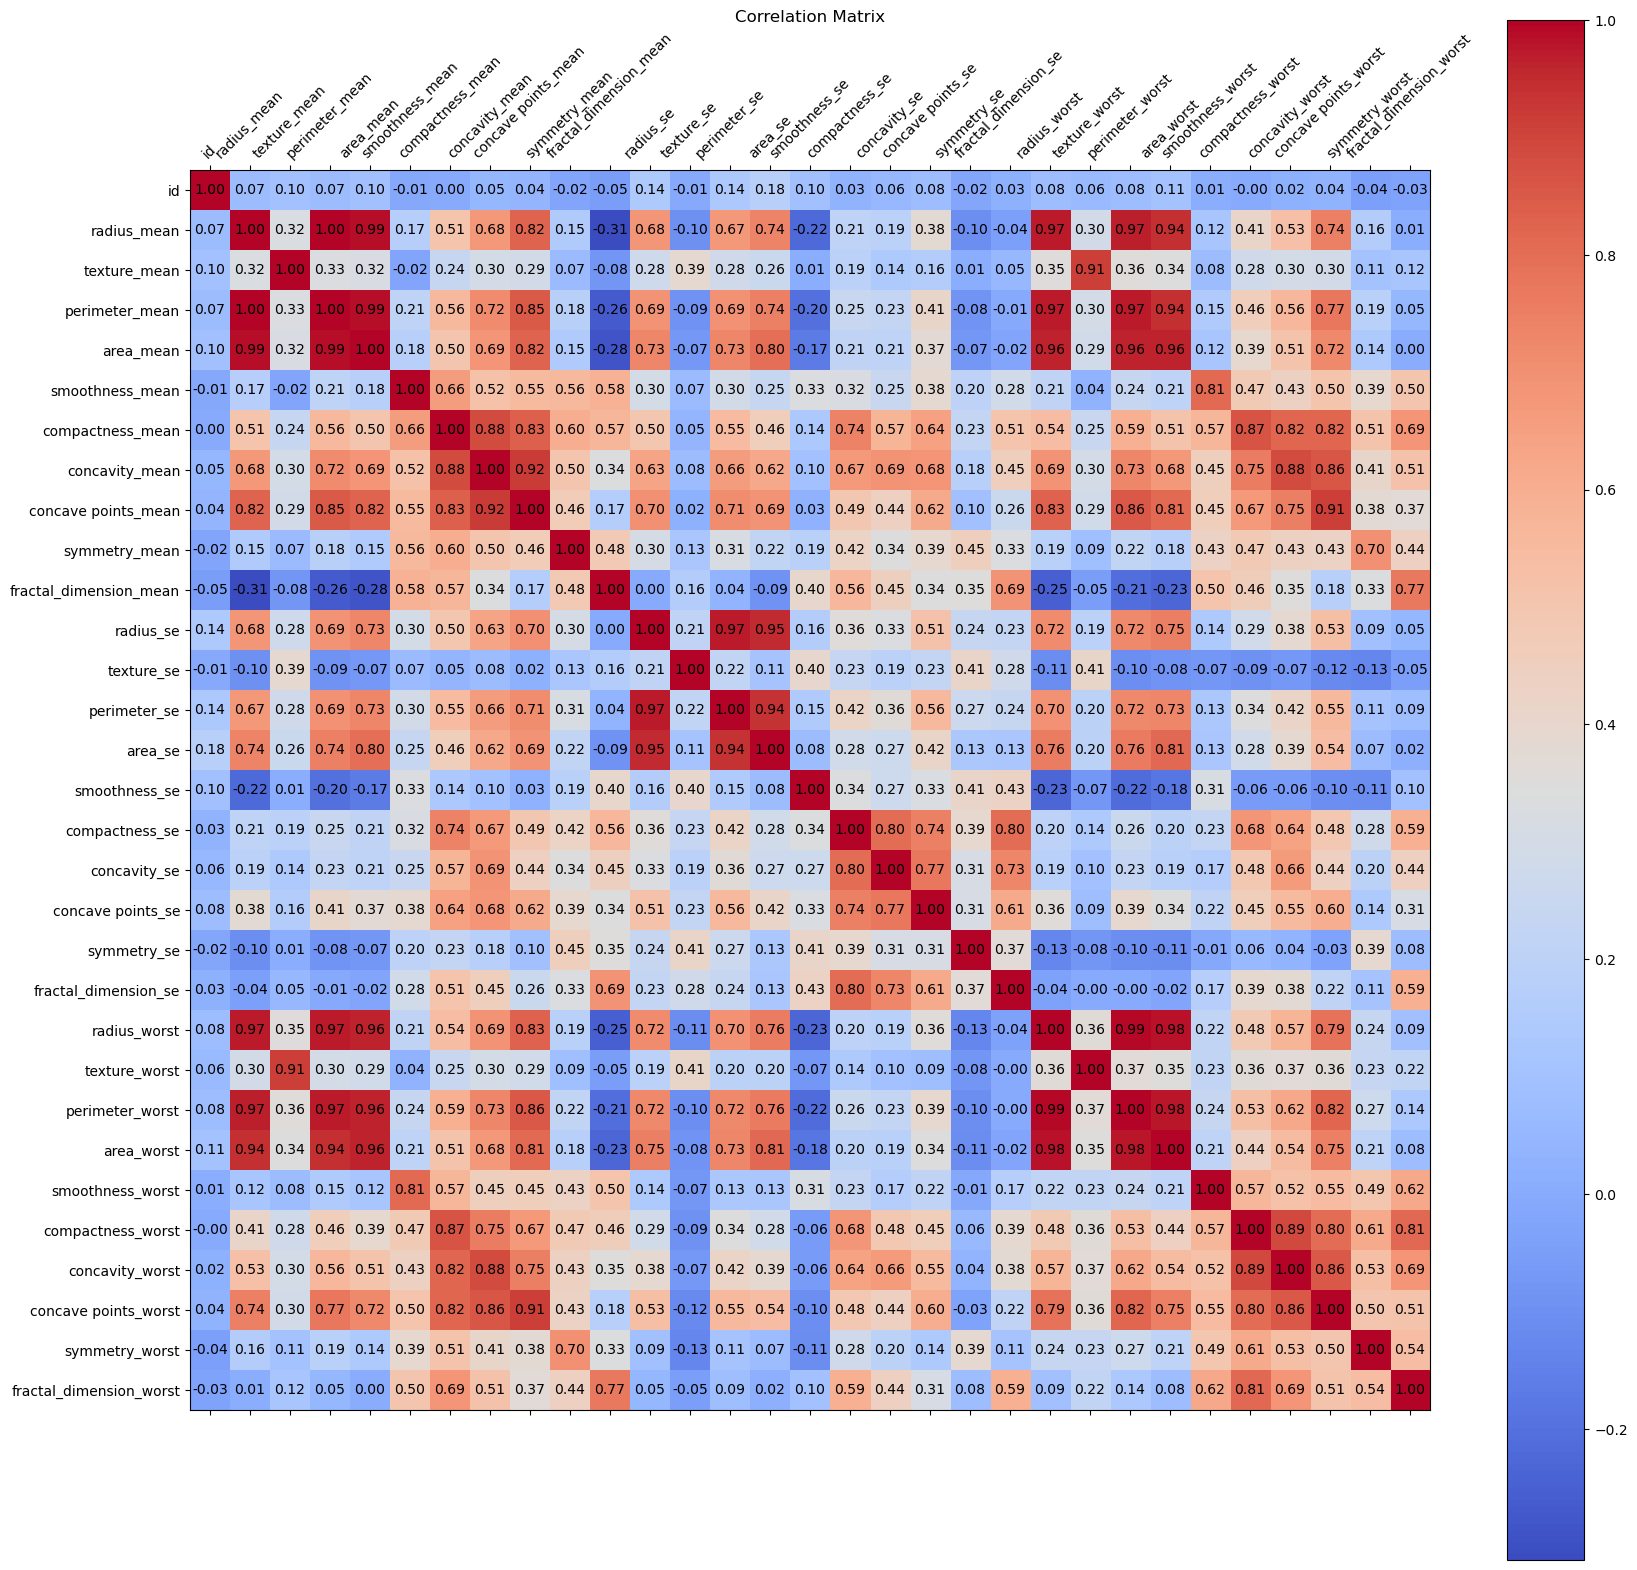

In [17]:
data2 = data.drop(columns={"diagnosis"})
corr_matrix = data2.corr()
fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.matshow(corr_matrix, cmap='coolwarm')

plt.colorbar(cax)

# Set axis labels
ax.set_xticks(range(len(data2.columns)))
ax.set_yticks(range(len(data2.columns)))

ax.set_xticklabels(data2.columns, rotation=45)
ax.set_yticklabels(data2.columns)

# Add numerical values
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

plt.title("Correlation Matrix")
plt.show()

## Feature Selection

To reduce overfitting and improve model performance, we used cross-validation in combination with three models: Logistic Regression, K-Nearest Neighbors, and Random Forest. This is to identify the most important features for predicting tumor malignancy.

Lots of the data is highly correlated, which is something we have to be mindful of when training our models

In [324]:
X_trainlog, X_testlog, y_trainlog, y_testlog = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.20,
                                                    shuffle=True) 

print((X_trainlog.shape))

(455, 30)


In [299]:
kf = KFold(n_splits=5, random_state=69, shuffle=True)
accuracy_scores_train = {}
accuracy_model_train = {}

accuracy_scores_test = {}
accuracy_model_test = {}


for i, (train_index, test_index) in enumerate(kf.split(X_trainlog, y_trainlog)):
    X_train, X_test = X_trainlog.iloc[train_index], X_trainlog.iloc[test_index]
    y_train, y_test = y_trainlog.iloc[train_index], y_trainlog.iloc[test_index]

    # standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    corr_matrix = X_train.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # drop the features that have a correlation above 0.7
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]
    X_train = X_train.drop(columns=to_drop)
    X_test = X_test[X_train.columns]

    # Fit a logistic regression model
    X_train = sm.add_constant(X_train)
    model = sm.Logit(y_train, X_train).fit()
    predictions_train = model.predict(X_train)
    predictions_class_train = (predictions_train >= 0.5).astype(int)

    accuracy_train = accuracy_score(y_train, predictions_class_train)

    accuracy_scores_train[accuracy_train] = X_train.columns
    accuracy_model_train[accuracy_train] = model

    pval = accuracy_model_train[max(accuracy_scores_train)].pvalues
    pval = pval[pval < 0.05].index.tolist()

    print(f"Fold {i+1} train - Selected Features: {pval}")
    print(f"Fold {i+1} train - Accuracy: {accuracy_train:.4f}")
    
    ##########################################################################################################

    X_test = sm.add_constant(X_test)
    predictions_test = model.predict(X_test)
    predictions_class_test = (predictions_test >= 0.5).astype(int)

    accuracy_test = accuracy_score(y_test, predictions_class_test)

    accuracy_scores_test[accuracy_test] = X_test.columns
    accuracy_model_test[accuracy_test] = model

    pval = accuracy_model_test[max(accuracy_scores_test)].pvalues
    pval = pval[pval < 0.05].index.tolist()

    print(f"Fold {i+1} test - Selected Features: {pval}")
    print(f"Fold {i+1} test - Accuracy: {accuracy_test:.4f}")

Optimization terminated successfully.
         Current function value: 0.162977
         Iterations 9
Fold 1 train - Selected Features: ['const', 'radius_mean', 'texture_mean', 'smoothness_mean']
Fold 1 train - Accuracy: 0.9396
Fold 1 test - Selected Features: ['const', 'radius_mean', 'texture_mean', 'smoothness_mean']
Fold 1 test - Accuracy: 0.9341
Optimization terminated successfully.
         Current function value: 0.157616
         Iterations 9
Fold 2 train - Selected Features: ['const', 'radius_mean', 'texture_mean', 'smoothness_mean', 'symmetry_mean']
Fold 2 train - Accuracy: 0.9423
Fold 2 test - Selected Features: ['const', 'radius_mean', 'texture_mean', 'smoothness_mean']
Fold 2 test - Accuracy: 0.9121
Optimization terminated successfully.
         Current function value: 0.132882
         Iterations 10
Fold 3 train - Selected Features: ['const', 'radius_mean', 'texture_mean', 'smoothness_mean', 'symmetry_se', 'symmetry_worst']
Fold 3 train - Accuracy: 0.9478
Fold 3 test - Sel

In [305]:
pval = accuracy_model_test[max(accuracy_scores_test.keys())].pvalues
pval = pval[pval < 0.05].drop("const").index.tolist()
summarize(accuracy_model_test[max(accuracy_scores_test)])

,coef,std err,z,P>|z|
const,-1.2441,0.361,-3.442,0.001
radius_mean,4.3189,0.995,4.342,0.000
texture_mean,1.2510,0.366,3.416,0.001
smoothness_mean,1.7232,0.609,2.829,0.005
compactness_mean,1.0522,1.060,0.993,0.321
symmetry_mean,-0.3376,0.576,-0.586,0.558
fractal_dimension_mean,-1.4440,0.937,-1.541,0.123
texture_se,0.5161,0.422,1.222,0.222
smoothness_se,0.8505,0.585,1.453,0.146
symmetry_se,-2.0515,0.578,-3.551,0.000


In [306]:
print(pval)

['radius_mean', 'texture_mean', 'smoothness_mean', 'symmetry_se', 'symmetry_worst']


In [308]:
log_features = pval

# test model with selected features
X_trainlog_features = X_trainlog[log_features]
X_testlog = X_testlog[log_features]

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_trainlog_features, y_trainlog)

# train accuracy
predictions_trainlog = log_model.predict(X_trainlog_features)
accuracy_trainlog = accuracy_score(y_trainlog, predictions_trainlog)
print("Train accuracy:", accuracy_trainlog)

predictions_testlog = log_model.predict(X_testlog)
accuracy_testlog = accuracy_score(predictions_testlog, y_testlog)
print("Test accuracy:", accuracy_testlog)
log_conf = confusion_table(predictions_testlog, y_testlog)
log_conf

Train accuracy: 0.8901098901098901
Test accuracy: 0.9298245614035088


Truth,0,1
Predicted,,
0,70,4
1,4,36


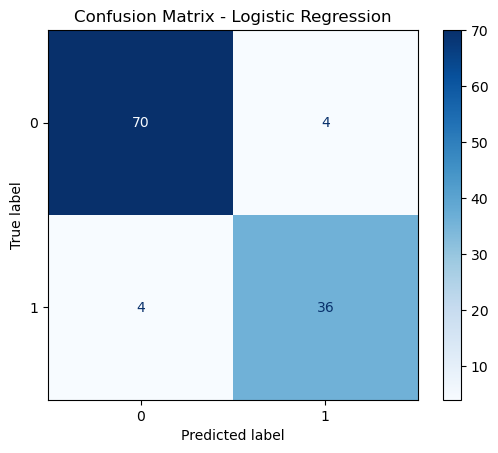

In [309]:
labels = ['Benign', 'Malignant'] if 'B' in y_test.values else None

disp_lr = ConfusionMatrixDisplay(confusion_matrix=np.array(log_conf), display_labels=labels)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [325]:
X_trainRF, X_testRF, y_trainRF, y_testRF = train_test_split(X,
                                                    y,
                                                    random_state=67,
                                                    test_size=0.20,
                                                    shuffle=True) 

X_trainRF.shape

(455, 30)

In [ ]:
kf = KFold(n_splits=5, random_state=69, shuffle=True)
accuracy_scores_train_RF = {}
accuracy_model_train_RF = {}

accuracy_scores_test_RF = {}
accuracy_model_test_RF = {}

for i, (train_index, test_index) in enumerate(kf.split(X_trainRF, y_trainRF)):
    X_train, X_test = X_trainRF.iloc[train_index], X_trainRF.iloc[test_index]
    y_train, y_test = y_trainRF.iloc[train_index], y_trainRF.iloc[test_index]
    print(X_train.columns)

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Use grid search to find the best hyperparameters for Random Forest
    param_grid = {'n_estimators': [25, 50, 100, 200], 'max_depth': [3,4,5], 'max_features': ["sqrt"]}
    grid = GridSearchCV(RC(), param_grid, cv=5)
    grid.fit(X_train, y_train)
    params = grid.best_params_

    model = RC(**params)
    model.fit(X_train, y_train)

    predictions_train = model.predict(X_train)

    accuracy_train = accuracy_score(y_train, predictions_train)

    accuracy_scores_train_RF[accuracy_train] = X_train.columns
    accuracy_model_train_RF[accuracy_train] = model

    feature_names = X_train.columns
    
    feature_imp = pd.DataFrame(
        {'importance':model.feature_importances_},
        index=feature_names)
    feature_imp.sort_values(by='importance', ascending=True)

    print(f"Fold {i+1} train - Selected Features: {feature_imp.index.tolist()}")
    print(f"Fold {i+1} train - Accuracy: {accuracy_train:.4f}")
    



#     predictions_class = RF_model.predict(X_test)
    
#     accuracy = accuracy_score(y_test, predictions_class)
#     accuracy_scores[accuracy] = feature_imp
#     accuracy_model[accuracy] = model

# print("Best accuracy:", max(accuracy_scores.keys()))

Index(['perimeter_worst', 'area_worst', 'concave points_mean',
       'concave points_worst', 'radius_worst'],
      dtype='object')
Index(['perimeter_worst', 'area_worst', 'concave points_mean',
       'concave points_worst', 'radius_worst'],
      dtype='object')
Fold 1 train - Selected Features: ['perimeter_worst', 'area_worst', 'concave points_mean', 'concave points_worst', 'radius_worst']
Fold 1 train - Accuracy: 0.9676
Index(['perimeter_worst', 'area_worst', 'concave points_mean',
       'concave points_worst', 'radius_worst'],
      dtype='object')
Fold 2 train - Selected Features: ['perimeter_worst', 'area_worst', 'concave points_mean', 'concave points_worst', 'radius_worst']
Fold 2 train - Accuracy: 0.9619
Index(['perimeter_worst', 'area_worst', 'concave points_mean',
       'concave points_worst', 'radius_worst'],
      dtype='object')
Fold 3 train - Selected Features: ['perimeter_worst', 'area_worst', 'concave points_mean', 'concave points_worst', 'radius_worst']
Fold 3 trai

In [311]:
scores = accuracy_scores[max(accuracy_scores)]
scores_sorted = scores.sort_values(by='importance', ascending=False)
top5 = scores_sorted.head(5)
print(top5)


                      importance
perimeter_worst           0.1776
area_worst                0.1370
concave points_mean       0.1354
concave points_worst      0.1316
radius_worst              0.1198


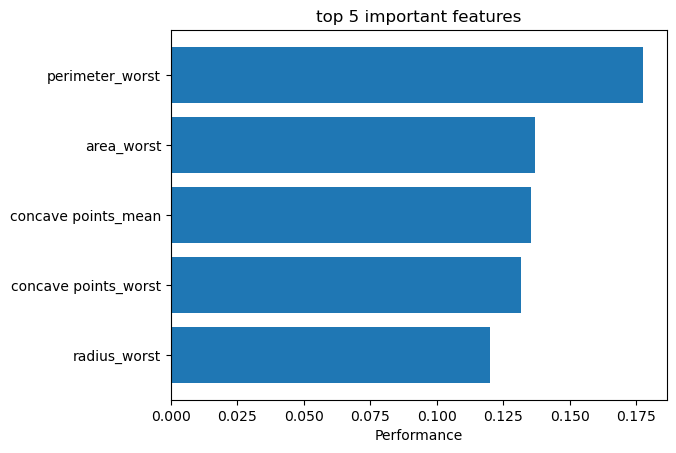

In [245]:
fig, ax = plt.subplots()
y_pos = np.arange(len(top5))
importance = top5['importance'].values

ax.barh(y_pos, importance, align='center')
ax.set_yticks(y_pos, labels=top5.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('top 5 important features')

plt.show()

In [156]:
RF_feature_names = top5.index.tolist()
RF_feature_names

['perimeter_worst',
 'area_worst',
 'concave points_mean',
 'concave points_worst',
 'radius_worst']

In [ ]:
X_features = X[RF_feature_names]

X_trainRF, X_testRF, y_trainRF, y_testRF = train_test_split(X_features,
                                                    y,
                                                    random_state=67,
                                                    test_size=0.25,
                                                    shuffle=True) 
RF_model = RC(max_features=5,
             n_estimators=1000,
             max_depth=5,
#             min_samples_leaf=2,
            max_leaf_nodes=3,
             bootstrap=True,
             random_state=)
RF_model.fit(X_trainRF, y_trainRF)
predictions_RF = RF_model.predict(X_testRF)
accuracy_RF = accuracy_score(predictions_RF, y_testRF)
print("accuracy", accuracy_RF)
RF_conf = confusion_table(predictions_RF, y_testRF)
RF_conf


accuracy 0.958041958041958


Truth,0,1
Predicted,,
0,91,4
1,2,46


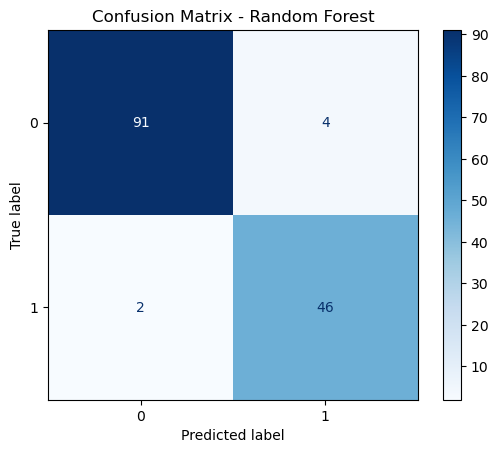

In [160]:
labels = ['Benign', 'Malignant'] if 'B' in y_test.values else None

disp_lr = ConfusionMatrixDisplay(confusion_matrix=np.array(RF_conf), display_labels=labels)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

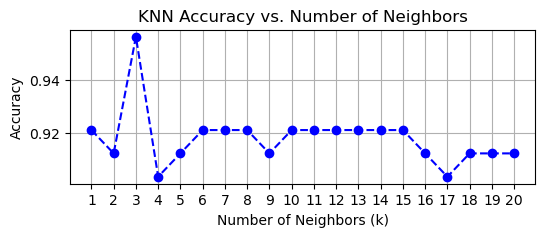

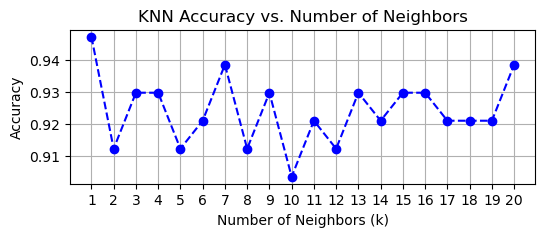

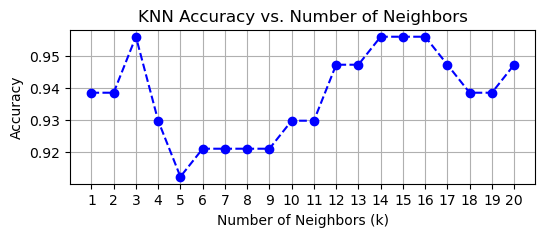

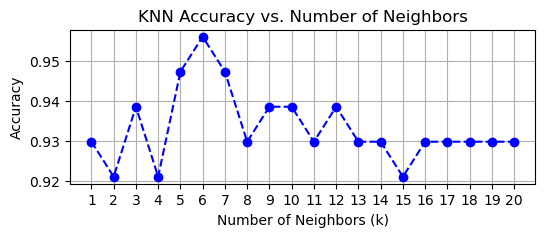

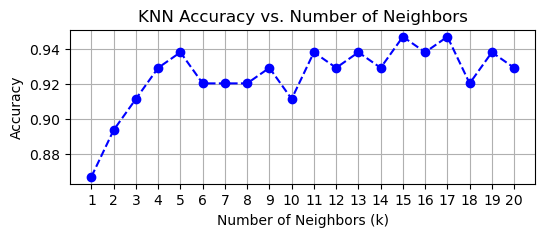

optimal_k: 5


In [ ]:
kf = KFold(n_splits=5, random_state=69, shuffle=True)
accuracy_scores_KNN = {}
accuracy_model_KNN = {}
k_values = range(1, 21)
acc = []
selected_features_per_fold = []  # Store best k for each fold
best_k_per_fold = []  # Store best k for averaging

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # remove highly correlated features from both train and test
    corr_matrix = X_train.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]
    X_train_selected = X_train.drop(columns=to_drop)
    X_test_selected = X_test[X_train_selected.columns]  

    X_train_knn = X_train_selected.to_numpy()
    X_test_knn = X_test_selected.to_numpy()


    for k in k_values:
        knn_model = KNN(n_neighbors=k)
        knn_model.fit(X_train_knn, y_train)
        knn_predictions = knn_model.predict(X_test_knn)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, knn_predictions)
        accuracy_scores_KNN[k] = accuracy
        acc.append(accuracy)
        accuracy_model_KNN[accuracy] = X_test_selected.columns.tolist()

    plt.figure(figsize=(6, 2))
    plt.plot(k_values, accuracy_lst, marker='o', linestyle='dashed', color='b')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('KNN Accuracy vs. Number of Neighbors')
    plt.xticks(np.arange(min(k_values), max(k_values)+1, step=1))
    plt.grid(True)
    plt.show()

    best_k = max(accuracy_scores_KNN, key=accuracy_scores_KNN.get)  # k with highest accuracy
    best_k_per_fold.append(best_k)  # Store best k for averaging

    accuracy_lst = []

optimal_k = int(np.mean(best_k_per_fold))  # Average best k
print("optimal_k:", optimal_k)


In [239]:
KNN_feature_names = accuracy_model_KNN[max(acc)]
KNN_feature_names

['radius_mean',
 'texture_mean',
 'smoothness_mean',
 'compactness_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'texture_se',
 'smoothness_se',
 'symmetry_se']

In [242]:
X_features_KNN = X[KNN_feature_names]

X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split(X_features_KNN,
                                                    y,
                                                    random_state=67,
                                                    test_size=0.25,
                                                    shuffle=True) 
KNN_model = KNN(n_neighbors=k)
KNN_model.fit(X_trainKNN, y_trainKNN)
predictions_KNN = KNN_model.predict(X_testKNN)
accuracy_KNN = accuracy_score(predictions_KNN, y_testKNN)
print("accuracy", accuracy_KNN)
KNN_conf = confusion_table(predictions_KNN, y_testKNN)
KNN_conf


accuracy 0.9300699300699301


Truth,0,1
Predicted,,
0,91,8
1,2,42


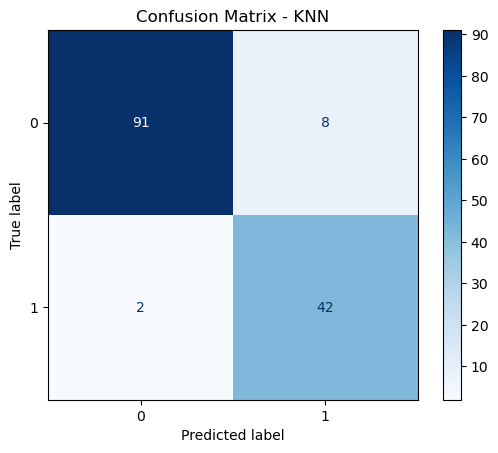

In [243]:
labels = ['Benign', 'Malignant'] if 'B' in y_test.values else None

disp_lr = ConfusionMatrixDisplay(confusion_matrix=np.array(KNN_conf), display_labels=labels)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
plt.show()